In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad import AscadDataset
from models.recurrent import LstmModel
from datasets.transforms import ToTensor
from training.training import execute_epoch, train_batch, eval_batch
from training.metrics import get_loss

In [2]:
retrain = False
num_epochs = 10
batch_size = 256
grad_clip_norm = 1.0
metrics = {'loss': get_loss}
results_dir = os.path.join('.', 'results', 'lstm_autoencoder')

In [3]:
train_dataset = AscadDataset(train=True, transform=ToTensor())
test_dataset = AscadDataset(train=False, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
model = LstmModel(delay=1, realistic_hindsight=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda'
model = model.to(device)

print('Model:', model)
print('Loss function:', loss_fn)
print('Optimizer:', optimizer)
print('Device:', device)

Model: LstmModel(
  (recurrent_layers): ModuleList(
    (0): LSTMCell(1, 64)
    (1): LSTMCell(64, 64)
    (2): LSTMCell(64, 64)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Loss function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Device: cuda


In [5]:
train_results = {}
test_results = {}

def train_epoch(update_params=True):
    if update_params:
        results = execute_epoch(train_batch, train_dataloader, model, loss_fn, optimizer, device,
                                batch_metric_fns=metrics, autoencoder=True, grad_clip_val=1.0)
    else:
        results = execute_epoch(eval_batch, train_dataloader, model, loss_fn, device,
                                batch_metric_fns=metrics, autoencoder=True)
    for key in results.keys():
        if not(key in train_results):
            train_results[key] = []
        train_results[key].append(results[key])

def test_epoch():
    results = execute_epoch(eval_batch, test_dataloader, model, loss_fn, device,
                            batch_metric_fns=metrics, autoencoder=True)
    for key in results.keys():
        if not(key in test_results):
            test_results[key] = []
        test_results[key].append(results[key])

if retrain:
    train_epoch(update_params=False)
    test_epoch()
    for epoch in tqdm(range(num_epochs)):
        train_epoch()
        test_epoch()

In [6]:
if retrain:
    os.makedirs(results_dir, exist_ok=True)
    with open(os.path.join(results_dir, 'train_results.pickle'), 'wb') as F:
        pickle.dump(train_results, F)
    with open(os.path.join(results_dir, 'test_results.pickle'), 'wb') as F:
        pickle.dump(test_results, F)
    torch.save(model, os.path.join(results_dir, 'trained_model.pt'))

In [7]:
with open(os.path.join(results_dir, 'train_results.pickle'), 'rb') as F:
    train_results = pickle.load(F)
with open(os.path.join(results_dir, 'test_results.pickle'), 'rb') as F:
    test_results = pickle.load(F)
model = torch.load(os.path.join(results_dir, 'trained_model.pt'))

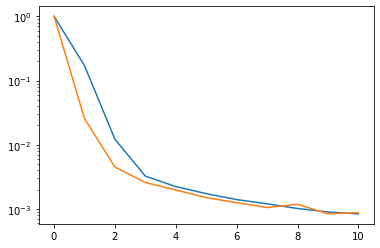

In [8]:
for k in train_results.keys():
    train_results[k] = [np.mean(x) for x in train_results[k]]
for k in test_results.keys():
    test_results[k] = [np.mean(x) for x in test_results[k]]
plt.plot(train_results['loss'])
plt.plot(test_results['loss'])
plt.yscale('log')

(<Figure size 576x288 with 2 Axes>,
 array([[<AxesSubplot:xlabel='Sample number', ylabel='Trace measurement'>,
         <AxesSubplot:xlabel='Sample number', ylabel='Reconstruction error'>]],
       dtype=object))

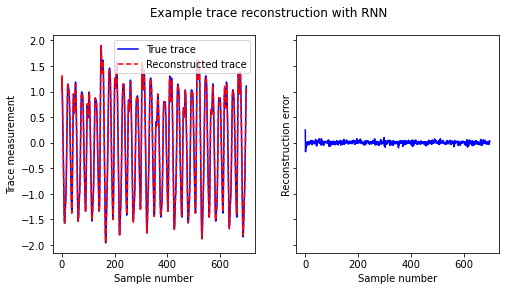

In [9]:
from display_results import plot_autoencoder_traces
traces = next(iter(test_dataloader))[0][:1]
plot_autoencoder_traces(traces, model, device)